# 第5章 决策树

熵越大，随机变量的不确定性越大

熵只依赖于X的分布，而与X的取值无关

- ID3（基于信息增益）
- C4.5（基于信息增益比）
- CART（gini指数）

#### entropy：$H(x) = -\sum_{i=1}^{n}p_i\log{p_i}$

#### conditional entropy: $H(X|Y)=\sum{P(X|Y)}\log{P(X|Y)}$

#### information gain : $g(D, A)=H(D)-H(D|A)$

#### information gain ratio: $g_R(D, A) = \frac{g(D,A)}{H(A)}$

#### gini index:$Gini(D)=\sum_{k=1}^{K}p_k\log{p_k}=1-\sum_{k=1}^{K}p_k^2$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter
import math
from math import log

import pprint

In [2]:
# 书上题目5.1
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

In [3]:
datasets,labels = create_data()

In [4]:
train_data = pd.DataFrame(datasets,columns=labels)

In [5]:
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


In [6]:
# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
    return ent

In [7]:
# 经验条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p)/data_length)*calc_ent(p) for p in feature_sets.values()])
    return cond_ent

In [8]:
# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent

In [10]:
def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [11]:
info_gain_train(np.array(datasets))

特征(年龄) - info_gain - 0.083
特征(有工作) - info_gain - 0.324
特征(有自己的房子) - info_gain - 0.420
特征(信贷情况) - info_gain - 0.363


'特征(有自己的房子)的信息增益最大，选择为根节点特征'

In [12]:
# 利用ID3算法生成决策树
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {'label:': self.label, 'feature': self.feature, 'tree': self.tree}

    def __repr__(self):
        return '{}'.format(self.result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)
    
class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p)/data_length)*self.calc_ent(p) for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :-1], train_data.iloc[:, -1], train_data.columns[:-1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True,
                        label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] == f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [13]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

{'否': {'label:': '否', 'feature': None, 'tree': {}},
 '是': {'label:': '是', 'feature': None, 'tree': {}}}
{'否': {'label:': None, 'feature': 1, 'tree': {'否': {'label:': '否', 'feature': None, 'tree': {}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}},
 '是': {'label:': '是', 'feature': None, 'tree': {}}}


In [14]:
tree

{'label:': None, 'feature': 2, 'tree': {'否': {'label:': None, 'feature': 1, 'tree': {'否': {'label:': '否', 'feature': None, 'tree': {}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}

In [15]:
dt.predict(['老年', '否', '否', '一般'])

'否'

In [16]:
# sklearn.tree.DecisionTreeClassifier

In [17]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:,:2], data[:,-1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
import graphviz

In [19]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
clf.score(X_test, y_test)

0.9333333333333333

In [21]:
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

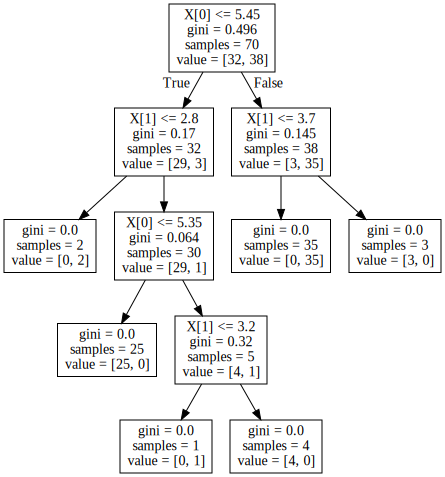

In [23]:
# 决策树可视化输出
graphviz.Source(dot_graph)

In [24]:
#ID3剪枝
import numpy as np
import pandas as pd
from collections import Counter
import math


class Node:
    def __init__(self, x=None, label=None, y=None, data=None):
        self.label = label   # label:子节点分类依据的特征
        self.x = x           # x:特征
        self.child = []      # child:子节点
        self.y = y           # y:类标记（叶节点才有）
        self.data = data     # data:包含数据（叶节点才有）

    def append(self, node):  # 添加子节点
        self.child.append(node)

    def predict(self, features):  # 预测数据所述类
        if self.y is not None:
            return self.y
        for c in self.child:
            if c.x == features[self.label]:
                return c.predict(features)


def printnode(node, depth=0):  # 打印树所有节点
    if node.label is None:
        print(depth, (node.label, node.x, node.y, len(node.data)))
    else:
        print(depth, (node.label, node.x))
        for c in node.child:
            printnode(c, depth+1)


class DTree:
    def __init__(self, epsilon=0, alpha=0):  # 预剪枝、后剪枝参数
        self.epsilon = epsilon
        self.alpha = alpha
        self.tree = Node()

    def prob(self, datasets):  # 求概率
        datalen = len(datasets)
        labelx = set(datasets)
        p = {l: 0 for l in labelx}
        for d in datasets:
            p[d] += 1
        for i in p.items():
            p[i[0]] /= datalen
        return p

    def calc_ent(self, datasets):  # 求熵
        p = self.prob(datasets)
        ent = sum([-v * math.log(v, 2) for v in p.values()])
        return ent

    def cond_ent(self, datasets, col):  # 求条件熵
        labelx = set(datasets.iloc[col])
        p = {x: [] for x in labelx}
        for i, d in enumerate(datasets.iloc[-1]):
            p[datasets.iloc[col][i]].append(d)
        return sum([self.prob(datasets.iloc[col])[k] * self.calc_ent(p[k]) for k in p.keys()])

    def info_gain_train(self, datasets, datalabels):  # 求信息增益（互信息）
        #print('----信息增益----')
        datasets = datasets.T
        ent = self.calc_ent(datasets.iloc[-1])
        gainmax = {}
        for i in range(len(datasets) - 1):
            cond = self.cond_ent(datasets, i)
            #print(datalabels[i], ent - cond)
            gainmax[ent - cond] = i
        m = max(gainmax.keys())
        return gainmax[m], m

    def train(self, datasets, node):
        labely = datasets.columns[-1]
        if len(datasets[labely].value_counts()) == 1:
            node.data = datasets[labely]
            node.y = datasets[labely][0]
            return
        if len(datasets.columns[:-1]) == 0:
            node.data = datasets[labely]
            node.y = datasets[labely].value_counts().index[0]
            return
        gainmaxi, gainmax = self.info_gain_train(datasets, datasets.columns)
        #print('选择特征：', gainmaxi)
        if gainmax <= self.epsilon:  # 若信息增益（互信息）为0意为输入特征x完全相同而标签y相反
            node.data = datasets[labely]
            node.y = datasets[labely].value_counts().index[0]
            return

        vc = datasets[datasets.columns[gainmaxi]].value_counts()
        for Di in vc.index:
            node.label = gainmaxi
            child = Node(Di)
            node.append(child)
            new_datasets = pd.DataFrame([list(i) for i in datasets.values if i[gainmaxi]==Di], columns=datasets.columns)
            self.train(new_datasets, child)

    def fit(self, datasets):
        self.train(datasets, self.tree)

    def findleaf(self, node, leaf):  # 找到所有叶节点
        for t in node.child:
            if t.y is not None:
                leaf.append(t.data)
            else:
                for c in node.child:
                    self.findleaf(c, leaf)

    def findfather(self, node, errormin):
        if node.label is not None:
            cy = [c.y for c in node.child]
            if None not in cy:  # 全是叶节点
                childdata = []
                for c in node.child:
                    for d in list(c.data):
                        childdata.append(d)
                childcounter = Counter(childdata)

                old_child = node.child  # 剪枝前先拷贝一下
                old_label = node.label
                old_y = node.y
                old_data = node.data

                node.label = None  # 剪枝
                node.y = childcounter.most_common(1)[0][0]
                node.data = childdata

                error = self.c_error()
                if error <= errormin:  # 剪枝前后损失比较
                    errormin = error
                    return 1
                else:
                    node.child = old_child  # 剪枝效果不好，则复原
                    node.label = old_label
                    node.y = old_y
                    node.data = old_data
            else:
                re = 0
                i = 0
                while i < len(node.child):
                    if_re = self.findfather(node.child[i], errormin)  # 若剪过枝，则其父节点要重新检测
                    if if_re == 1:
                        re = 1
                    elif if_re == 2:
                        i -= 1
                    i += 1
                if re:
                    return 2
        return 0

    def c_error(self):  # 求C(T)
        leaf = []
        self.findleaf(self.tree, leaf)
        leafnum = [len(l) for l in leaf]
        ent = [self.calc_ent(l) for l in leaf]
        print("Ent:", ent)
        error = self.alpha*len(leafnum)
        for l, e in zip(leafnum, ent):
            error += l*e
        print("C(T):", error)
        return error

    def cut(self, alpha=0):  # 剪枝
        if alpha:
            self.alpha = alpha
        errormin = self.c_error()
        self.findfather(self.tree, errormin)


datasets = np.array([['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '一般', '是']])  # 在李航原始数据上多加了最后这行数据，以便体现剪枝效果

datalabels = np.array(['年龄', '有工作', '有自己的房子', '信贷情况', '类别'])
train_data = pd.DataFrame(datasets, columns=datalabels)
test_data = ['老年', '否', '否', '一般']

dt = DTree(epsilon=0)  # 可修改epsilon查看预剪枝效果
dt.fit(train_data)

print('DTree:')
printnode(dt.tree)
y = dt.tree.predict(test_data)
print('result:', y)

dt.cut(alpha=0.5)  # 可修改正则化参数alpha查看后剪枝效果

print('DTree:')
printnode(dt.tree)
y = dt.tree.predict(test_data)
print('result:', y)


DTree:
0 (2, None)
1 (1, '否')
2 (0, '否')
3 (3, '青年')
4 (None, '一般', '否', 3)
4 (None, '好', '否', 1)
3 (None, '中年', '否', 2)
3 (None, '老年', '否', 1)
2 (None, '是', '是', 3)
1 (None, '是', '是', 6)
result: 否
Ent: [0.9182958340544896, 0.0, 0.0, 0.0, 0.0, 0.0]
C(T): 5.754887502163468
Ent: [0.8112781244591328, 0.0, 0.0, 0.0, 0.0]
C(T): 5.745112497836532
Ent: [0.5916727785823275, 0.0, 0.0]
C(T): 5.641709450076292
Ent: [0.9709505944546686, 0.0]
C(T): 10.709505944546686
DTree:
0 (2, None)
1 (1, '否')
2 (None, '否', '否', 7)
2 (None, '是', '是', 3)
1 (None, '是', '是', 6)
result: 否
